# Fashion Mnist Dataset Convolutional Neural Network Optimized with Dropout, Batch Normalization and L2 Regularization using Pytorch

## Import Libraries

In [1]:
# library to see model summary
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import kagglehub
import random
import matplotlib.pyplot as plt
from torchinfo import summary

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Loading the Dataset

In [4]:
dataset_path = kagglehub.dataset_download('zalando-research/fashionmnist')
csv_file_path = f'{dataset_path}/fashion-mnist_train.csv'
df_train = pd.read_csv(csv_file_path)

Using Colab cache for faster access to the 'fashionmnist' dataset.


In [5]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_train.shape

(60000, 785)

In [7]:
csv_file_path = f'{dataset_path}/fashion-mnist_test.csv'
df_test = pd.read_csv(csv_file_path)

In [8]:
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_test.shape

(10000, 785)

## Viewing the Random Image

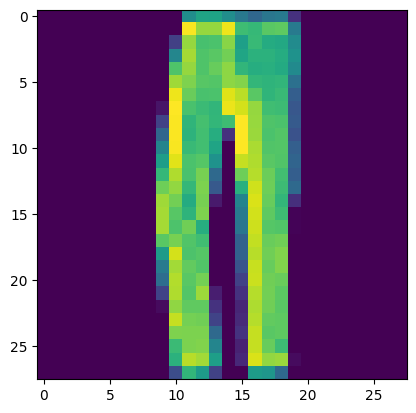

In [10]:
# train image
random_index = random.randint(0,len(df_train))
image = df_train.iloc[random_index,1:].values.reshape(28,28)
plt.imshow(image)
plt.show()

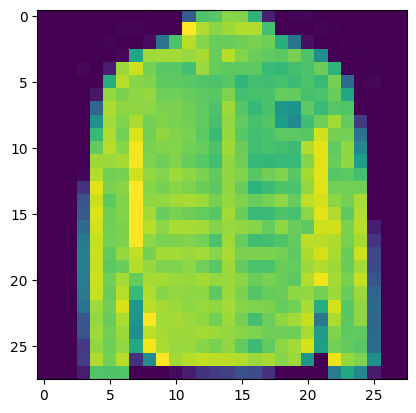

In [11]:
# test image
random_index = random.randint(0,len(df_test))
image = df_test.iloc[random_index,1:].values.reshape(28,28)
plt.imshow(image)
plt.show()

## Splitting the Dataset into Training and Testing Sets

In [12]:
X_train = df_train.iloc[:, 1:].values
y_train = df_train.iloc[:, 0].values
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [13]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## Creating Custom Dataset Class

In [14]:
class CustomDataset(Dataset):

    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [15]:
train_datataset = CustomDataset(features=X_train, labels=y_train)
test_datataset = CustomDataset(features=X_test, labels=y_test)

In [16]:
train_dataloader = DataLoader(train_datataset, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_datataset, batch_size=32, shuffle=False, pin_memory=True)

## Model Building, Training and Evaluation

In [24]:
# crating model Class
class Model(nn.Module):

    def __init__(self, input_channel):
        super().__init__()
        # convolutional layers
        self.features_extraction = nn.Sequential(
            # first layer
            nn.Conv2d(in_channels=input_channel, out_channels=32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # second layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # fully connected layers
        self.classifier = nn.Sequential(
            # first layer
            nn.Flatten(),
            nn.LazyLinear(out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            
            # second layer
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # output layer
            nn.Linear(in_features=64, out_features=10)
        )

    def forward(self, x):
        x = self.features_extraction(x)
        return self.classifier(x)

In [25]:
learning_rate=0.01
epochs=100

In [26]:
# creatind model object of Mode Class we creates above
model = Model(input_channel=1).to(device)

# loss function
loss_function = nn.CrossEntropyLoss()

# optimizer with weight decay for L2 regularization
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [32]:
print(summary(model, input_size=(1,1,28,28)))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 7, 7]             --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─BatchNorm2d: 2-3                  [1, 32, 28, 28]           64
│    └─MaxPool2d: 2-4                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 64, 14, 14]           18,496
│    └─ReLU: 2-6                         [1, 64, 14, 14]           --
│    └─BatchNorm2d: 2-7                  [1, 64, 14, 14]           128
│    └─MaxPool2d: 2-8                    [1, 64, 7, 7]             --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Flatten: 2-9                      [1, 3136]                 --
│    └─Linear: 2-10                      [1, 128]                  401,536
│   

In [28]:
# training loop
for epoch in range(epochs):

    total_epoch_loss=0
    for batch_features, batch_labels in train_dataloader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # forward pass
        y_pred = model(batch_features)
        
        # loss calculate
        loss = loss_function(y_pred, batch_labels)
        
        # clear gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # calculate loss for each batchs
        total_epoch_loss += loss.item()

    # average loss of batches
    avg_loss = total_epoch_loss/len(train_dataloader)

    print(f"Epoch: {epoch + 1}, Loss:{avg_loss}")

Epoch: 1, Loss:0.5925321457147599
Epoch: 2, Loss:0.3579170604844888
Epoch: 3, Loss:0.3067008399407069
Epoch: 4, Loss:0.27406981954574583
Epoch: 5, Loss:0.25118665264844897
Epoch: 6, Loss:0.23370979818900425
Epoch: 7, Loss:0.2178742322385311
Epoch: 8, Loss:0.20531358996431032
Epoch: 9, Loss:0.19758250829279422
Epoch: 10, Loss:0.18413830808500448
Epoch: 11, Loss:0.17525041127403576
Epoch: 12, Loss:0.16326057152599097
Epoch: 13, Loss:0.15765847524404525
Epoch: 14, Loss:0.14885819066887102
Epoch: 15, Loss:0.1425560404919088
Epoch: 16, Loss:0.1362689320926865
Epoch: 17, Loss:0.12831948484287908
Epoch: 18, Loss:0.12217920727990568
Epoch: 19, Loss:0.1170210087283204
Epoch: 20, Loss:0.11163872574058671
Epoch: 21, Loss:0.10810667069690923
Epoch: 22, Loss:0.1009476254407006
Epoch: 23, Loss:0.09600899982936681
Epoch: 24, Loss:0.09051541214672228
Epoch: 25, Loss:0.08864017092757859
Epoch: 26, Loss:0.08558808168123165
Epoch: 27, Loss:0.08218068408388644
Epoch: 28, Loss:0.07757379400897771
Epoch: 29

In [29]:
# setting model to evaluation mode
model.eval()

Model(
  (features_extraction): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [30]:
# evaluation code
total = 0 
correct = 0
with torch.no_grad():

    for batch_features, batch_labels in test_dataloader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        y_pred = model(batch_features)

        _, predicted = torch.max(y_pred, 1)

        total += batch_labels.shape[0]

        correct += (predicted==batch_labels).sum().item()

print(f"Accuracy on Test Data: {(correct/total)*100}%")

Accuracy on Test Data: 93.10000000000001%


In [31]:
# evaluation code
total = 0 
correct = 0
with torch.no_grad():

    for batch_features, batch_labels in train_dataloader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        y_pred = model(batch_features)

        _, predicted = torch.max(y_pred, 1)

        total += batch_labels.shape[0]

        correct += (predicted==batch_labels).sum().item()

print(f"Accuracy on Train Data: {(correct/total)*100}%")

Accuracy on Train Data: 99.90666666666667%
